# Mapping

In [64]:
try:
    import time
    import numpy as np
    import BWT
    from matplotlib import pyplot as plt
    from importlib import reload
    from colorama import Fore
    reload(BWT)
    print("Done")
except:
    print("You have to install all packages in requirements.txt")

Done


In [65]:
### Test with sars_cov_2.txt:
seq = ''
with open("data/sars_cov_2.txt", 'r') as file:
    for line in file:
        seq += line.replace('\n', '')
N=1000
print(f"Longueur de la séquence : {len(seq)}, traitement de {N} nucléotides.")

start=time.time()
my_BWT = BWT.BWT(seq[0:N] + '$')
# print("Text sequence: ",my_BWT.text)
my_BWT.compute_sufixe_array()
print("suffix array done")
my_BWT.construct_bwt()
print("BTW done")
stop=time.time()
print("Time cumsumtion: {:.1f} sec".format(stop-start))
# print(my_BWT.L)

Longueur de la séquence : 29903, traitement de 1000 nucléotides.
suffix array done
BTW done
Time cumsumtion: 2.6 sec


In [66]:
x = "ATTA"
print(f"BWT search of {x} :")
occurences = my_BWT.bwt_search(x)
print(f"{x} figures {len(occurences) if occurences!= None else 0} times in the seq at positions : ", end='')
try:
    for o in occurences: print(o[1], end=' ')
    print('\n')
    start, end = 0, occurences[0][1]
    for i in range(len(occurences)):
        print(Fore.WHITE + my_BWT.text[start:end], end='')
        print(Fore.RED + my_BWT.text[end:end+len(x)], end='')
        start = end+len(x)
        try:
            end = occurences[i+1][1]
        except:
            break
    print(Fore.WHITE + my_BWT.text[start:])
except:
    pass

BWT search of ATTA :
ATTA figures 4 times in the seq at positions : 0 131 142 865 

ATTAAAGGTTTATACCTTCCCAGGTAACAAACCAACCAACTTTCGATCTCTTGTAGATCTGTTCTCTAAACGAACTTTAAAATCTGTGTGGCTGTCACTCGGCTGCATGCTTAGTGCACTCACGCAGTATAATTAATAACTAATTACTGTCGTTGACAGGACACGAGTAACTCGTCTATCTTCTGCAGGCTGCTTACGGTTTCGTCCGTGTTGCAGCCGATCATCAGCACATCTAGGTTTCGTCCGGGTGTGACCGAAAGGTAAGATGGAGAGCCTTGTCCCTGGTTTCAACGAGAAAACACACGTCCAACTCAGTTTGCCTGTTTTACAGGTTCGCGACGTGCTCGTACGTGGCTTTGGAGACTCCGTGGAGGAGGTCTTATCAGAGGCACGTCAACATCTTAAAGATGGCACTTGTGGCTTAGTAGAAGTTGAAAAAGGCGTTTTGCCTCAACTTGAACAGCCCTATGTGTTCATCAAACGTTCGGATGCTCGAACTGCACCTCATGGTCATGTTATGGTTGAGCTGGTAGCAGAACTCGAAGGCATTCAGTACGGTCGTAGTGGTGAGACACTTGGTGTCCTTGTCCCTCATGTGGGCGAAATACCAGTGGCTTACCGCAAGGTTCTTCTTCGTAAGAACGGTAATAAAGGAGCTGGTGGCCATAGTTACGGCGCCGATCTAAAGTCATTTGACTTAGGCGACGAGCTTGGCACTGATCCTTATGAAGATTTTCAAGAAAACTGGAACACTAAACATAGCAGTGGTGTTACCCGTGAACTCATGCGTGAGCTTAACGGAGGGGCATACACTCGCTATGTCGATAACAACTTCTGTGGCCCTGATGGCTACCCTCTTGAGTGCATTAAAGACCTTCTAGCACGTGCTGGTAAAGCTTCATGCACTTTGTCCGAA

## Cut the sequence for mapping

In [67]:
def Sequence_Cut(seq: str, K: int, overlap = 10):
    """Cut the sequence into seqences of length K

    Args:
        seq (str): sequence
        K (int): length of the cuts
        overlap (int, optional): lenght of the overlaps. Defaults to 10.

    Raises:
        Exception: K<overlap

    Returns:
        list[(index, seq)] : cuts
    """
    if K<overlap:
        raise Exception("K must be higher than overlap")
    cuts = []
    n=0
    while n+K<len(seq):
        cuts.append((n, seq[n:n+K]))
        n+=K-overlap
    cuts.append((n, seq[n:]))
    return cuts
    

In [70]:
### Test with sars_cov_2.txt:
seq = ''
with open("data/sars_cov_2.txt", 'r') as file:
    for line in file:
        seq += line.replace('\n', '')
N=10000
seq = seq[:N]
K = 1000
print(f"Longueur de la séquence : {len(seq)}, traitement de {N} nucléotides avec des cuts de longueur {K}.")

start=time.time()
cuts = Sequence_Cut(seq, K, overlap=10)
my_BWT_list = []
for c in cuts:
    my_BWT_list.append((c[0],BWT.BWT(c[1] + '$')))
    # print("Text sequence: ",my_BWT.text)
    my_BWT_list[-1][1].compute_sufixe_array()
    my_BWT_list[-1][1].construct_bwt()
stop=time.time()
print("Time cumsumtion: {:.1f} sec".format(stop-start))
# print(my_BWT.L)

Longueur de la séquence : 10000, traitement de 10000 nucléotides avec des cuts de longueur 1000.
Time cumsumtion: 24.6 sec


In [71]:
x = "ATTA"
print(f"BWT search of {x} :")
occurences = []
for bwt in my_BWT_list:
    tmp = bwt[1].bwt_search(x)
    occurences += [o[1] + bwt[0] for o in tmp]
#remove duplicates:
occurences = list(dict.fromkeys(occurences))
print(f"{x} figures {len(occurences) if occurences!= None else 0} times in the seq at positions : ", end='')
try:
    for o in occurences: print(o, end=' ')
    print('\n')
    start, end = 0, occurences[0]
    for i in range(len(occurences)):
        print(Fore.WHITE + seq[start:end], end='')
        print(Fore.RED + seq[end:end+len(x)], end='')
        start = end+len(x)
        try:
            end = occurences[i+1]
        except:
            break
    print(Fore.WHITE + seq[start:])
    print(len(seq))
except:
    print("yoyo")

BWT search of ATTA :
ATTA figures 63 times in the seq at positions : 0 131 142 865 1033 1687 1748 2065 2275 2344 2479 2559 2617 2928 3125 3297 3382 3530 3705 3708 4039 4235 4339 4425 4489 4514 4871 4966 4993 5211 5263 5360 5753 5851 5957 5960 6176 6487 6520 6583 6600 6612 6683 6764 6832 6911 6949 6969 7189 7339 7369 7436 7657 7876 7989 8359 8584 8883 9145 9290 9293 9740 9858 

ATTAAAGGTTTATACCTTCCCAGGTAACAAACCAACCAACTTTCGATCTCTTGTAGATCTGTTCTCTAAACGAACTTTAAAATCTGTGTGGCTGTCACTCGGCTGCATGCTTAGTGCACTCACGCAGTATAATTAATAACTAATTACTGTCGTTGACAGGACACGAGTAACTCGTCTATCTTCTGCAGGCTGCTTACGGTTTCGTCCGTGTTGCAGCCGATCATCAGCACATCTAGGTTTCGTCCGGGTGTGACCGAAAGGTAAGATGGAGAGCCTTGTCCCTGGTTTCAACGAGAAAACACACGTCCAACTCAGTTTGCCTGTTTTACAGGTTCGCGACGTGCTCGTACGTGGCTTTGGAGACTCCGTGGAGGAGGTCTTATCAGAGGCACGTCAACATCTTAAAGATGGCACTTGTGGCTTAGTAGAAGTTGAAAAAGGCGTTTTGCCTCAACTTGAACAGCCCTATGTGTTCATCAAACGTTCGGATGCTCGAACTGCACCTCATGGTCATGTTATGGTTGAGCTGGTAGCAGAACTCGAAGGCATTCAGTACGGTCGTAGTGGTGAGACACTTGGTGTCCTTGTCCCTCATGTGGGCGAAATACCAGTGGCTTACC

## Genome Mapping

In [92]:
read_length=100
read_sigma=50
fold_coverage=1
full_sequence=my_BWT.text

def create_reads(full_sequence,read_length=150,read_sigma=50,fold_coverage=5):
	"""Create a list of shuffled samples of the sequence

	Args:
		full_sequence (str): full sequence
		read_length (int, optional): mean sample length. Defaults to 150.
		read_sigma (int, optional): sigma. Defaults to 50.
		fold_coverage (int, optional): number of times we cover the sequence. Defaults to 5.

	Returns:
		list[str]: samples
	"""
	reads_list=[]
	for i in range(fold_coverage):
		n=0
		while n<len(full_sequence):
			rand_int=int(np.random.normal(read_length,read_sigma))
			if n+rand_int<len(full_sequence):
				read=full_sequence[n:n+rand_int]
			else:
				read=full_sequence[n:]
			n+=rand_int
			if read != "":
				reads_list.append(read)
	np.random.shuffle(reads_list)
	# reads_list=np.array(reads_list)
	return reads_list

reads=create_reads(full_sequence,read_length,read_sigma,fold_coverage)

In [73]:
for read in reads:
    occurences = my_BWT.bwt_search(read)
    print("#occurences: ",len(occurences)," position: ",str(occurences[0][1]))

#occurences:  1  position:  270
#occurences:  1  position:  114
#occurences:  1  position:  769
#occurences:  1  position:  730
#occurences:  1  position:  0
#occurences:  1  position:  932
#occurences:  1  position:  830
#occurences:  1  position:  75
#occurences:  1  position:  56
#occurences:  1  position:  618
#occurences:  1  position:  468
#occurences:  1  position:  589
#occurences:  1  position:  362


In [74]:
def non_ambiguous_mapping(BWT,reads,len_sequence):
	association_table=[]
	reconstructed_seq=len_sequence*['*']
	flag=False
	for i,read in enumerate(reads):
		occurences = BWT.bwt_search(read)
		if len(occurences)>1:
			flag=True
			# print("Read with morethen 1 occurence")
		index=occurences[0][1]
		reconstructed_seq[index:index+len(read)]=list(read)
	return("".join(reconstructed_seq),flag)
  
start=time.time()
reconstructed_seq,ambiguity=non_ambiguous_mapping(my_BWT,reads,len(full_sequence))
stop=time.time()
print("Mapping time:",stop-start)
reconstructed_seq==full_sequence

Mapping time: 0.0019936561584472656


True

## Time performences - count table

In [75]:
genome_size=np.linspace(500,2000,10)
read_length=np.linspace(10,400,40)
read_sigma=2
fold_coverage=1

time_cumsumption_BWT=np.zeros((3,len(genome_size)))
time_cumsumption_mapping=np.zeros( (len(genome_size),len(read_length)))
ambiguities=np.zeros( (len(genome_size),len(read_length)))
reconstructions=np.zeros( (len(genome_size),len(read_length)))

for i,N in enumerate(genome_size):
    N=int(N)
    start=time.time()
    my_BWT = BWT.BWT(seq[:N] + '$')
    stop_init=time.time()
    my_BWT.compute_sufixe_array()
    stop_suffix=time.time()
    my_BWT.construct_bwt()
    stop=time.time()
    time_cumsumption_BWT[0,i]=stop_init-start
    time_cumsumption_BWT[1,i]=stop_suffix-stop_init
    time_cumsumption_BWT[2,i]=stop-stop_suffix
    for j,K in enumerate(read_length):
        K=int(K)
        reads=create_reads(my_BWT.text,K,read_sigma,fold_coverage)
        start=time.time()
        reconstructed_seq,ambiguity=non_ambiguous_mapping(my_BWT,reads,len(my_BWT.text))
        stop=time.time()
        time_cumsumption_mapping[i,j]=stop-start
        ambiguities[i,j]=ambiguity
        reconstructions[i,j]=(reconstructed_seq==my_BWT.text)
    print(str(i+1),"/",len(genome_size))
        
        

1 / 10
2 / 10
3 / 10
4 / 10
5 / 10
6 / 10
7 / 10
8 / 10
9 / 10
10 / 10


[]

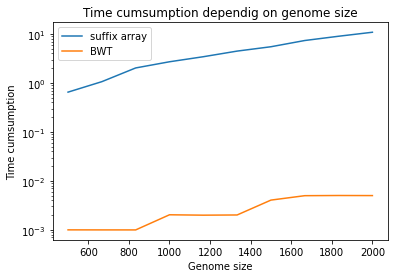

In [76]:
# plt.plot(genome_size,time_cumsumption_BWT[0,:],label='init')
plt.title("Time cumsumption dependig on genome size")
plt.plot(genome_size,time_cumsumption_BWT[1,:],label='suffix array')
plt.plot(genome_size,time_cumsumption_BWT[2,:],label='BWT')
plt.xlabel("Genome size")
plt.ylabel("Time cumsumption")
plt.legend()
plt.yscale("log")
plt.plot()

Text(0.5, 1.0, 'Time cumsumption in ms')

<Figure size 1440x360 with 0 Axes>

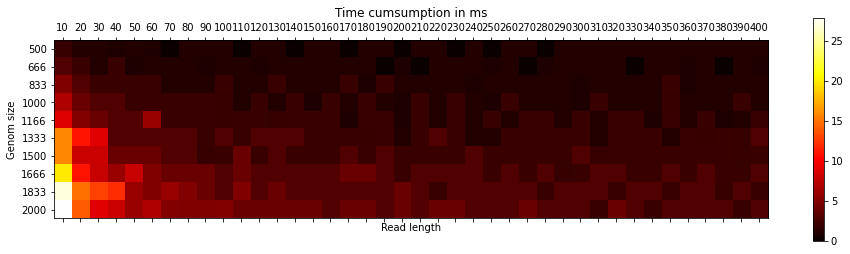

In [77]:
plt.figure(figsize=(20,5))
plt.matshow(time_cumsumption_mapping*1000,cmap='hot')
plt.xticks(np.arange(0,len(read_length)),labels=(int(s) for s in read_length))
plt.xlabel("Read length")
plt.yticks(np.arange(0,len(genome_size)),labels=(int(s) for s in genome_size))
plt.ylabel("Genom size")
plt.colorbar()
plt.title("Time cumsumption in ms")

In [98]:
read_length=100
read_sigma=10
fold_coverage=1
seq = ''
K = 1000
with open("data/sars_cov_2.txt", 'r') as file:
    for line in file:
        seq += line.replace('\n', '')
reads=create_reads(seq,read_length,read_sigma,fold_coverage)
start=time.time()
cuts = Sequence_Cut(seq, K, overlap=200)
my_BWT_list = []
for c in cuts:
    my_BWT_list.append((c[0],BWT.BWT(c[1] + '$')))
    # print("Text sequence: ",my_BWT.text)
    my_BWT_list[-1][1].compute_sufixe_array()
    my_BWT_list[-1][1].construct_bwt()
stop=time.time()

In [102]:
print("Time cumsumtion: {:.1f} sec".format(stop-start))
reconstructed_seq=len(seq)*['*']
flag = False
ambigous_reads = []
for i, read in enumerate(reads):
    occurences = []
    for bwt in my_BWT_list:
        tmp = bwt[1].bwt_search(read)
        occurences += [o[1] + bwt[0] for o in tmp]
    #remove duplicates:
    occurences = list(dict.fromkeys(occurences))
    #print(f"The read {i} figures {len(occurences) if occurences!= None else 0} times in the seq at positions : {occurences}", end='\r')
    if len(occurences)>1:
        flag = True
        print(f"The read {i} figures {len(occurences) if occurences!= None else 0} times in the seq at positions : {occurences}")
        ambigous_reads.append((read, occurences))
    else:
        for j in range(len(read)):
            reconstructed_seq[j+occurences[0]]=read[j]
for read_occurences in ambigous_reads:
    read, occurences = read_occurences[0], read_occurences[1]
    for o in occurences:
        if seq[o]=='*':
            for j in range(len(read)):
                reconstructed_seq[j+occurences[0]]=read[j]
            break
print(flag)
print(reconstructed_seq==seq)

Time cumsumtion: 105.2 sec
The read 228 figures 9 times in the seq at positions : [29870, 29871, 29872, 29873, 29874, 29875, 29876, 29877, 29878]
True
False


In [100]:
reads[228]

'AAAAAAAAAAAAAAAAAAAAAAAAA'

In [115]:
x = 'ATTTACTCATTCGTAAGTCTAATCATAATTTCTTGGTACAGGCTGGTAATGTTCAACTCAGGGTTATTGGACATTCTATGCAAAATTGTGTACTTAAGCTTAAGGTTGATACAGCCAATCCTAAGACAC'
print(f"BWT search of a {len(x)}-length word :")
start = time.time()
occurences = []
for bwt in my_BWT_list:
    tmp = bwt[1].bwt_search(x)
    occurences += [o[1] + bwt[0] for o in tmp]
#remove duplicates:
occurences = list(dict.fromkeys(occurences))
print(f"The word figures {len(occurences) if occurences!= None else 0} times in the seq at positions : ", end='')
try:
    for o in occurences: print(o, end=' ')
except:
    pass
bwt_time = time.time()-start
print(f"\nTime used : {bwt_time}s")


print(f"Naive research of a {len(x)}-length word :")
occurences = []
for i in range(len(seq)):
    flag = True
    for j in range(len(x)):
        if i+j>=len(seq) or seq[i+j]!=x[j]:
            flag = False
            break
    if flag:
        occurences.append(i)
print(f"The word figures {len(occurences) if occurences!= None else 0} times in the seq at positions : ", end='')
try:
    for o in occurences: print(o, end=' ')
except:
    pass
bwt_time = time.time()-start
print(f"\nTime used : {bwt_time}s")

BWT search of a 129-length word :
The word figures 1 times in the seq at positions : 10220 
Time used : 0.0049877166748046875s
Naive research of a 129-length word :
The word figures 1 times in the seq at positions : 10220 
Time used : 0.029919147491455078s


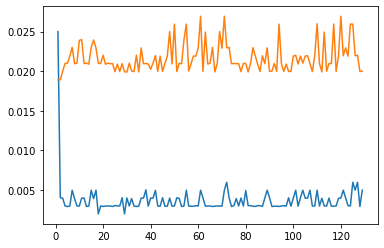

In [117]:
big_word = 'ATTTACTCATTCGTAAGTCTAATCATAATTTCTTGGTACAGGCTGGTAATGTTCAACTCAGGGTTATTGGACATTCTATGCAAAATTGTGTACTTAAGCTTAAGGTTGATACAGCCAATCCTAAGACAC'
index = [i for i in range(1, len(big_word)+1)]
time_naive = []
time_bwt = []
for i in range(1, len(big_word)+1):
    x = big_word[:i]
    start = time.time()
    occurences = []
    for bwt in my_BWT_list:
        tmp = bwt[1].bwt_search(x)
        occurences += [o[1] + bwt[0] for o in tmp]
    #remove duplicates:
    occurences = list(dict.fromkeys(occurences))
    time_bwt.append(time.time()-start)

    start = time.time()
    occurences = []
    for i in range(len(seq)):
        flag = True
        for j in range(len(x)):
            if i+j>=len(seq) or seq[i+j]!=x[j]:
                flag = False
                break
        if flag:
            occurences.append(i)
    time_naive.append(time.time()-start)
plt.plot(index, time_bwt)
plt.plot(index, time_naive)
plt.show()